Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel $\rightarrow$ Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell $\rightarrow$ Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [461]:
NAME = "JAKUB ANTCZAK"

---

# Naiwny Bayes

Model Naiwnego Bayesa jest jednym z najprostszych modeli grafowych. Zakłada on, że wszystkie obserwowane zmienne $X_1, X_2, \ldots, X_N$ są warunkowo niezależne względem zmiennej $Y$ oraz, że jedyna zależność istnieje między zmienną $Y$ a zmiennymi $\mathbf{X}$ (zobacz rysunek). 

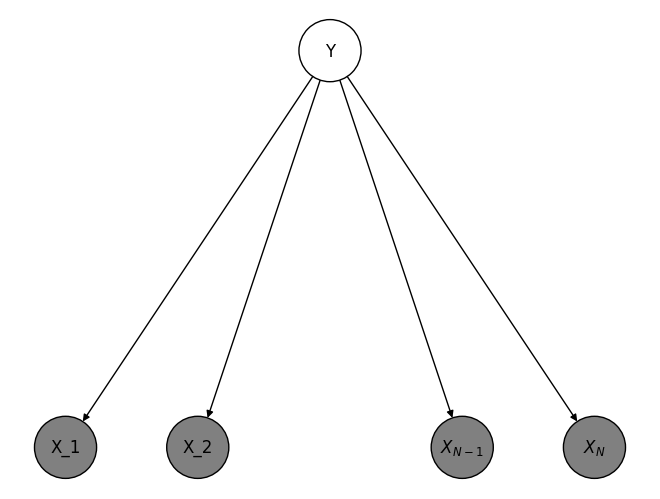

In [462]:
import networkx as nx
    
g = nx.DiGraph()
g.add_edges_from([("Y", "X_1"), ("Y", "X_2"), ("Y", "$X_{N-1}$"), ("Y", "$X_N$")])

nx.draw(
    g, 
    with_labels=True, 
    node_color=["gray" if "X" in v else "white" for v in g.nodes()],
    pos={"Y": (0, 0), "X_1": (-2, -1), "X_2": (-1, -1), "$X_{N-1}$": (1, -1), "$X_N$": (2, -1)},
    edgecolors="black",
    node_size=2000,
)

## Naiwny klasyfikator Bayesa

Naszym celem będzie rozwiązać zadanie klasyfikacji, gdzie klasa będzie reprezentowana przez zmienną $Y$ (zakładamy, że istnieje $K$ klas), natomiast atrybuty opisujące dane instancje to $X_1, X_2, \ldots, X_N$ (wartości te mogą być zarówno ciągłe, jak i dyskretne). 

Dla konkretnej instancji opisanej $x_1, x_2, \ldots, x_N$ poszukujemy jej rzeczywistej klasy $\hat y$, którą uzyskujemy maksymalizując prawdopodobieństwo warunkowe klasy $y_k$ pod warunkiem danych $x_1, x_2, \ldots, x_N$:

$$\tag{1}\hat{y} = \operatorname*{argmax}_{k \in \{1, 2, \ldots, K\}} \mathbb{P}(y_k | x_1, x_2, \ldots, x_N)$$

Wykorzystując regułę Bayesa możemy to prawdopodobieństwo rozpisać jako:

$$\mathbb{P}(y_k|x_1, x_2, \ldots, x_N) = \frac{\mathbb{P}(y_k)\mathbb{P}(x_1, x_2, \ldots, x_N | y_k)}{\mathbb{P}(x_1, x_2, \ldots, x_N)}$$

Licznik tego ułamka możemy zapisać jako prawdopodbieństwo łączne:

$$\tag{2}\mathbb{P}(y_k)\mathbb{P}(x_1, x_2, \ldots, x_N | y_k) = \mathbb{P}(y_k, x_1, x_2, \ldots, x_N)$$

Dodatkowo możemy pominąć mianownik i zapisać, że prawdopodobieństwo $\text{(1)}$ jest proporcjonalne do $\text{(2)}$:

$$\mathbb{P}(y_k|x_1, x_2, \ldots, x_N) \propto \mathbb{P}(y_k, x_1, x_2, \ldots, x_N)$$

Korzystając wielokrotnie z reguły łańcuchowej możemy dokonać faktoryzacji prawdopodobieństwa łącznego:

$$\tag{3}
\begin{align}
\mathbb{P}(y_k, x_1, x_2, \ldots, x_N) & = \mathbb{P}(x_1, x_2, \ldots, x_N, y_k)\\
& = \mathbb{P}(x_1 | x_2, \ldots, x_N, y_k)\mathbb{P}(x_2, \ldots, x_N, y_k) \\
& \ldots \\
& = \mathbb{P}(x_1 | x_2, \ldots, x_N, y_k)\mathbb{P}(x_2 | \ldots, x_N, y_k) \ldots \mathbb{P}(x_{N-1}|x_N, y_k) \mathbb{P}(x_N | y_k)\mathbb{P}(y_k)
\end{align}
$$

"Naiwność" tego modelu zakłada, że zmienne $X_1, \ldots, X_N$ są niezależne pod warunkiem $Y$, stąd:

$$\tag{4}\mathbb{P}(x_i | x_{i+1}, x_{i+2}, \ldots, x_N, y_k) = \mathbb{P}(x_i|y_k)$$

Aplikując $\text{(4)}$ do $\text{(3)}$ otrzymujemy:

$$\mathbb{P}(y_k|x_1, x_2, \ldots, x_N) \propto \mathbb{P}(y_k, x_1, x_2, \ldots, x_N) = \mathbb{P}(y_k)\mathbb{P}(x_1|y_k)\mathbb{P}(x_2|y_k)\ldots\mathbb{P}(x_N|y_k) = \mathbb{P}(y_k)\prod_{i=1}^{N}\mathbb{P}(x_i|y_k)$$

$$\mathbb{P}(y_k|x_1, x_2, \ldots, x_N) \propto \mathbb{P}(y_k)\prod_{i=1}^{N}\mathbb{P}(x_i|y_k)$$

Ostatecznie otrzymujemy:

$$\hat y = \operatorname*{argmax}_{k \in \{1, 2, \ldots, K\}} \mathbb{P}(y_k)\prod_{i=1}^{N}\mathbb{P}(x_i|y_k)$$

# Zmienne ciągłe
Będziemy się tutaj posługiwać zbiorem danych Iris, który posiada tylko ciągłe atrybuty.

In [463]:
import pandas as pd
from sklearn import datasets as sk_ds
from sklearn import model_selection as sk_ms


def load_iris_dataset():
    X, y = sk_ds.load_iris(return_X_y=True)
    X = pd.DataFrame(X, columns=[
        "sepal-length",
        "sepal-width",
        "petal-length",
        "petal-width",
    ])

    X_tr, X_te, y_tr, y_te = sk_ms.train_test_split(X, y, train_size=0.8, stratify=y)
    print("Full", X.shape, y.shape)
    print("Train", X_tr.shape, y_tr.shape)
    print("Test", X_te.shape, y_te.shape)

    return {
        "train": {"X": X_tr, "y": y_tr},
        "test": {"X": X_te, "y": y_te},
    }


iris = load_iris_dataset()

Full (150, 4) (150,)
Train (120, 4) (120,)
Test (30, 4) (30,)


In [464]:
iris["train"]["X"].head()

,sepal-length,sepal-width,petal-length,petal-width
2,4.7,3.2,1.3,0.2
74,6.4,2.9,4.3,1.3
29,4.7,3.2,1.6,0.2
122,7.7,2.8,6.7,2.0
30,4.8,3.1,1.6,0.2


In [465]:
iris["train"]["y"]

array([0, 1, 0, 2, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1,
       2, 1, 1, 2, 1, 0, 0, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1,
       0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 2, 1, 1, 0, 1, 2, 0, 1, 2, 2, 1, 2,
       0, 0, 2, 2, 0, 2, 1, 1, 1, 2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 0, 2, 2,
       0, 0, 0, 1, 2, 2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 1, 0, 2, 0, 1, 1, 1,
       2, 2, 1, 2, 0, 0, 1, 1, 2, 1])

### Implementacja w bibliotece `scikit-learn`
Załóżmy, że wszystkie zmienne tutaj pochodzą z rozkładu normalnego - użyjemy klasy `GaussianNB` (model naiwnego Bayesa z rozkładami normalnymi)

In [466]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics as sk_mtr


clf_scikit = GaussianNB()
clf_scikit.fit(X=iris["train"]["X"], y=iris["train"]["y"])

for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(
        y_true=iris[split]["y"],
        y_pred=clf_scikit.predict(X=iris[split]["X"]),
    ))

train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.93      0.93        40
           2       0.93      0.93      0.93        40

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Implementacja w bibliotece `pgmpy`

## Zadanie 1 (0.75 pkt)

Zaimplementuj funkcję `discretize_data`, która dokona dyskretyzacji (np. `KBinsDiscretizer`) zmiennych ciągłych w zadanym zbiorze danych. Zmienne kategoryczne/dyskretne nie powinny zostać zmienione. 

In [467]:
from copy import deepcopy
from sklearn.preprocessing import KBinsDiscretizer


def discretize_data(dataset: dict, n_bins: int) -> dict:
    _dataset = deepcopy(dataset)
    
    X_train = _dataset["train"]["X"]
    X_test = _dataset["test"]["X"]
    
    discrete_cols = X_train.select_dtypes('category').columns.values
    continuous_cols = [c for c in X_train.columns if c not in discrete_cols]
    
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    X_train_cont = discretizer.fit_transform(X_train[continuous_cols])
    X_test_cont = discretizer.transform(X_test[continuous_cols])

    X_train_discrete = X_train.copy()
    X_train_discrete[continuous_cols] = X_train_cont
    
    X_test_discrete = X_test.copy()
    X_test_discrete[continuous_cols] = X_test_cont
    
    _dataset["train"]["X"] = X_train_discrete
    _dataset["test"]["X"] = X_test_discrete
    
    
    # TU WPISZ KOD
    #raise NotImplementedError()
    
    return _dataset

## Zadanie 2 (0.3 pkt)

Zaimplementuj funkcję `build_model`, która zbuduje model Naiwnego Bayesa na podstawie obiektu `BayesianNetwork` (nie wykorzytuj klasy `NaiveBayes` z pgmpy!).

In [468]:
try:
    from pgmpy.models import BayesianNetwork
except ImportError:
    from pgmpy.models import BayesianModel as BayesianNetwork # for backward compatibility


def build_model(dataset: dict) -> BayesianNetwork:
    model = BayesianNetwork()
    model.add_node("class")

    for col in dataset["train"]["X"].columns:
        model.add_node(col)
        model.add_edge("class", col)
    return model
    #raise NotImplementedError()

## Zadanie 3 (0.4 pkt)

Zaimplementuj funkcję `fit_model`, która dopasuje parametry modelu Naiwnego Bayesa. Użyj dowolnej metody estymacji (np. Maximum Likelihood)

In [469]:
from pgmpy.estimators import MaximumLikelihoodEstimator

def fit_model(model: BayesianNetwork, training_data: dict) -> BayesianNetwork:
    train_df = training_data["X"].copy()
    train_df["class"] = training_data["y"]
    mle = MaximumLikelihoodEstimator(model=model, data=train_df)
    cpds = mle.get_parameters()
    model.add_cpds(*cpds)
    return model

## Zadanie 4 (0.75 pkt)

Zaimplementuj funkcję `predict_pgmpy`, która zwróci predykcje modelu Naiwnego Bayesa dla zadanych danych `X`. Użyj dowolnej metody inferencji (np. Variable Elimination).

In [470]:
from pgmpy.inference import VariableElimination
def predict_pgmpy(model, X):
    inference = VariableElimination(model)
    y_pred = []
    for i, x in X.iterrows():
        y_pred.append(inference.map_query(variables=["class"], evidence=x.to_dict(), show_progress=False)["class"])
    return y_pred

In [471]:
from pgmpy.inference import VariableElimination
def predict_pgmpy(model, X):
    inference = VariableElimination(model)
    y_pred = []
    for i, x in X.iterrows():
        y_pred.append(inference.map_query(variables=["class"], evidence=x.to_dict(), show_progress=False)["class"])
    return y_pred

Wykorzystajmy teraz zaimplementowane funkcje, aby wyuczyć model Naiwnego Bayesa w pgmpy i sprawdźmy jakość działania modelu na zdyskretyzowanych danych. 

In [472]:
iris_discrete = discretize_data(dataset=iris, n_bins=5)

c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [473]:
iris_discrete = discretize_data(dataset=iris, n_bins=5)
clf_pgmpy = build_model(dataset=iris_discrete)
clf_pgmpy = fit_model(model=clf_pgmpy, training_data=iris_discrete["train"])

c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [474]:
iris_discrete = discretize_data(dataset=iris, n_bins=5)
clf_pgmpy = build_model(dataset=iris_discrete)
clf_pgmpy = fit_model(model=clf_pgmpy, training_data=iris_discrete["train"])


for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(y_true=iris_discrete[split]["y"], y_pred=predict_pgmpy(model=clf_pgmpy, X=iris_discrete[split]["X"]),))

train

c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.92      0.90      0.91        40
           2       0.90      0.93      0.91        40

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120

test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


# Zmienne ciągłe i dyskretne
Wykorzystaj zbiór CMC, aby sprawdzić wszystkie modele na zbiorze z cechami dyskretnymi i ciągłymi.

In [475]:
def load_cmc(N=-1):
    # Source: https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice
    df = pd.read_csv('data/cmc.data', names=[
        'age', # numerical
        'w-education', # categorical
        'h-education',  # categorical
        'num-children',  # numerical
        'w-religion',  # binary
        'w-working',  # binary
        'h-occupation',  # categorical
        'sol-index',  # categorical
        'media-exposure',  # binary
        'contraceptive-method-used',  # class
    ])

    cat_cols = [
        'w-education', # categorical
        'h-education',  # categorical
        'h-occupation',  # categorical
        'sol-index',  # categorical
    ]
    bin_cols = [
        'w-religion',  # binary
        'w-working',  # binary
        'media-exposure',  # binary
    ]

    for col in cat_cols:
        df[col] = (df[col] - 1).astype('category')

    for col in bin_cols:
        df[col] = df[col].astype('category')    

    if N != -1:
        df = df.sample(
            n=N,
            weights='contraceptive-method-used',
            random_state=2020,
        )

    X = df[df.columns[:-1]]
    y = df['contraceptive-method-used'].values - 1

    X_tr, X_te, y_tr, y_te = sk_ms.train_test_split(X, y, train_size=0.8, stratify=y)
    print('Full', X.shape, y.shape)
    print('Train', X_tr.shape, y_tr.shape)
    print('Test', X_te.shape, y_te.shape)

    return {
        'train': {'X': X_tr.reset_index(drop=True), 'y': y_tr},
        'test': {'X': X_te.reset_index(drop=True), 'y': y_te},
    }

In [476]:
cmc = load_cmc(N=200)

Full (200, 9) (200,)
Train (160, 9) (160,)
Test (40, 9) (40,)


In [477]:
cmc["train"]["X"].head()

,age,w-education,h-education,num-children,w-religion,w-working,h-occupation,sol-index,media-exposure
0,34,3,3,5,1,1,2,3,0
1,23,3,3,0,0,1,1,3,0
2,24,3,3,1,1,1,0,2,0
3,26,3,3,1,1,1,0,3,0
4,27,2,2,3,1,1,1,1,0


In [478]:
cmc["train"]["y"]

array([1, 0, 2, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 0, 2, 2, 0,
       2, 1, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 1, 1, 1, 0, 2, 0, 1, 2, 0, 0,
       1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 2, 1, 2, 1,
       0, 2, 2, 1, 0, 1, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       0, 2, 0, 1, 2, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 0,
       1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 2, 0,
       2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1,
       0, 2, 1, 0, 1, 2], dtype=int64)

## Zadanie 5 (0.2 pkt)

Porównaj jakość działania implementacji Naiwnego Bayesa z biblioteki `scikit` oraz `pgmpy` na zbiorze CMC. Pamiętaj o dyskretyzacji danych w przypadku modelu z biblioteki pgmpy.

In [479]:
# Scikit 
clf_scikit = GaussianNB()
clf_scikit.fit(X=cmc["train"]["X"], y=cmc["train"]["y"])
for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(
        y_true=cmc[split]["y"],
        y_pred=clf_scikit.predict(X=cmc[split]["X"]),
    ))
# TU WPISZ KOD
#raise NotImplementedError()

train
              precision    recall  f1-score   support

           0       0.58      0.26      0.35        43
           1       0.24      0.97      0.38        34
           2       1.00      0.02      0.05        83

    accuracy                           0.29       160
   macro avg       0.61      0.42      0.26       160
weighted avg       0.72      0.29      0.20       160

test
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        10
           1       0.22      0.89      0.36         9
           2       0.00      0.00      0.00        21

    accuracy                           0.25        40
   macro avg       0.24      0.36      0.21        40
weighted avg       0.17      0.25      0.15        40



c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [480]:
# Pgmpy
cmc_discrete = discretize_data(dataset=cmc, n_bins=5)
clf_pgmpy = build_model(dataset=cmc_discrete)
clf_pgmpy = fit_model(model=clf_pgmpy, training_data=cmc_discrete["train"])


for split in ("train", "test"):
    print(split)
    print(sk_mtr.classification_report(y_true=cmc_discrete[split]["y"], y_pred=predict_pgmpy(model=clf_pgmpy, X=cmc_discrete[split]["X"]),))

# TU WPISZ KOD
#raise NotImplementedError()

train


c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.63      0.44      0.52        43
           1       0.45      0.53      0.49        34
           2       0.64      0.70      0.67        83

    accuracy                           0.59       160
   macro avg       0.58      0.56      0.56       160
weighted avg       0.60      0.59      0.59       160

test
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.54      0.78      0.64         9
           2       0.82      0.86      0.84        21

    accuracy                           0.72        40
   macro avg       0.72      0.68      0.67        40
weighted avg       0.75      0.72      0.72        40

